In [1]:
from config import AppConfig
from app_runner import AppRunner
from ui import show_ui

cfg = AppConfig()
runner = AppRunner(cfg)
runner.start()

built, ui_loop = show_ui(cfg, runner, ui_hz=10.0)

[1768800449.4s] Runner: started


[1768800451.2s] Camera: connected id=0 model=Mars-C sensor=IMX462 usb3=True bayer=POA_BAYER_RG max=1944x1096
[1768800453.9s] Mount: connected (Arduino conectado en /dev/cu.usbserial-1130 (PING=READY ENABLE=OK STOP=OK))
[1768800457.4s] Camera: reconfigure (restart stream) due to exp_ms change
[1768800457.6s] Camera: connected id=0 model=Mars-C sensor=IMX462 usb3=True bayer=POA_BAYER_RG max=1944x1096

[fr.raw] shape=(1096, 1944) dtype=uint16 C=True
  min/p1/p5/p50/p95/p99/max = [1.6000e+01 1.7120e+03 2.6560e+03 5.4080e+03 8.7200e+03 1.0192e+04
 6.5504e+04]
  mean=5.51e+03 std=1.85e+03
  sat65535=0.0000

[fr.u8_view] shape=(1096, 1944) dtype=uint8 C=True
  min/p1/p5/p50/p95/p99/max = [  0.   6.  10.  21.  34.  39. 255.]
  mean=21.1 std=7.23
  sat255=0.0000


In [3]:
from astroquery.simbad import Simbad

result = Simbad.query_object("Regulus")
result

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,matched_id
,deg,deg,mas,mas,deg,,,
object,float64,float64,float32,float32,int16,str1,object,object
* alf Leo,152.09296243828146,11.967208776100023,3.0791728,1.849461,90,O,2007A&A...474..653V,NAME Regulus


In [3]:
from platesolve import save_gaia_auth

save_gaia_auth("jtapia", "AzVnJSQqx7mzpL_")

In [ ]:
# Boton stop montura no funciona
# boton tracking no activa tracking

[1768797500.9s] ERROR: Platesolve: failed
Traceback (most recent call last):
  File "/Users/josue/proyectos/astropanoptes_project/astropanoptes/app_runner.py", line 601, in _platesolve_worker
    result = platesolve_from_live(
        frame,
    ...<3 lines>...
        progress_cb=None,
    )
  File "/Users/josue/proyectos/astropanoptes_project/astropanoptes/platesolve.py", line 1301, in platesolve_from_live
    return platesolve_sweep(
        frame,
    ...<6 lines>...
        progress_cb=progress_cb,
    )
  File "/Users/josue/proyectos/astropanoptes_project/astropanoptes/platesolve.py", line 1029, in platesolve_sweep
    det_xy, det_flux = detect_stars_sep(
                       ~~~~~~~~~~~~~~~~^
        gray_ds,
        ^^^^^^^^
    ...<3 lines>...
        progress_cb=progress_cb,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/josue/proyectos/astropanoptes_project/astropanoptes/platesolve.py", line 762, in detect_stars_sep
    bkg = sep.Background(data)
  File "sep.pyx", line 426, in sep.Background.__cinit__
  File "sep.pyx", line 323, in sep._parse_arrays
  File "sep.pyx", line 245, in sep._check_array_get_dims
ValueError: array is not C-contiguous


# por downsample, slice
# cambiar minimo estrellas para platesolve
# arreglar logs, mostrar todos los errores
# sep no detecta nada
# falta definir el radio de busqueda

Detecciones: 5 (fallback=False)
Flux: min=337  median=1.53e+04  max=6.01e+04


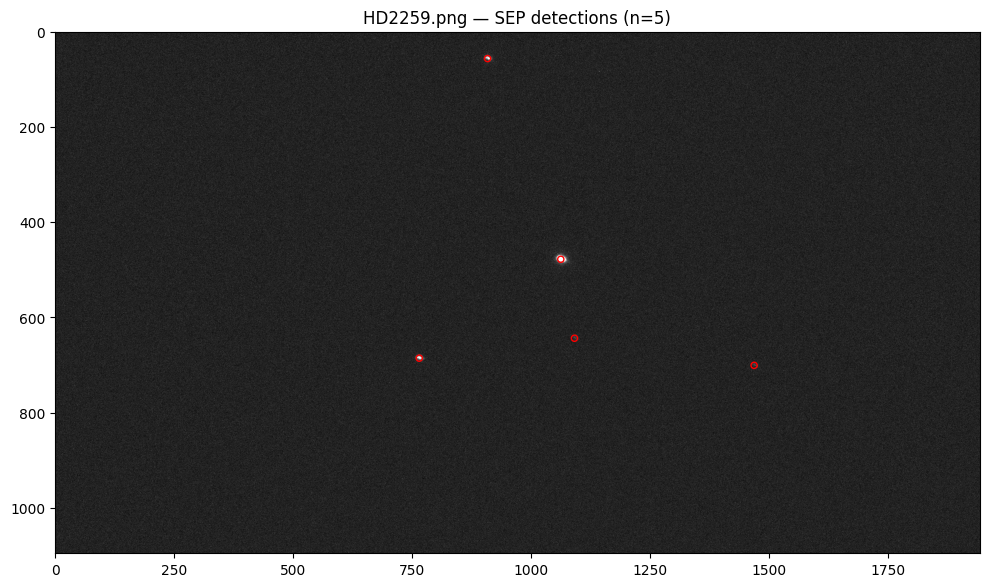

In [2]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt


def load_png_u8(path: str | Path) -> np.ndarray:
    p = str(path)
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"No pude abrir {p}")
    return img


def to_gray_float32_contig(img: np.ndarray) -> np.ndarray:
    # Convierte a gris y a float32, y fuerza contigüidad (C-order)
    if img.ndim == 2:
        gray = img
    elif img.ndim == 3 and img.shape[2] >= 3:
        # OpenCV lee BGR
        gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"Forma de imagen no soportada: {img.shape}")

    # float32 contiguo
    return np.ascontiguousarray(gray.astype(np.float32))


def main():
    img_path = Path("HD2259.png")
    img = load_png_u8(img_path)

    # --- Import: opción A (paquete) ---
    try:
        from astropanoptes import platesolve as ps
    except Exception:
        # --- Import: opción B (archivo local platesolve.py) ---
        # Ajusta esta ruta si tu platesolve.py está en otro lado
        ps_path = Path("astropanoptes") / "platesolve.py"
        if not ps_path.exists():
            ps_path = Path("platesolve.py")
        if not ps_path.exists():
            raise RuntimeError(
                "No pude importar astropanoptes.platesolve ni encontrar platesolve.py local. "
                "Ejecuta este script desde la raíz del repo o ajusta ps_path."
            )
        import importlib.util

        spec = importlib.util.spec_from_file_location("platesolve", str(ps_path))
        ps = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(ps)

    # Parámetros razonables para empezar (ajústalos si hay poco contraste)
    max_sources = 500
    thresh_sigma = 3.5
    minarea = 5

    # Intento 1: llamada directa a tu función
    try:
        xy, flux = ps.detect_stars_sep(
            img,
            max_sources=max_sources,
            thresh_sigma=thresh_sigma,
            minarea=minarea,
            progress_cb=None,
        )
        used_fallback = False

    except ValueError as e:
        # Si cae en "array is not C-contiguous", hacemos fallback sin editar el repo:
        # replicamos la lógica usando sep con un array contiguo.
        msg = str(e)
        if "C-contiguous" not in msg:
            raise

        print("detect_stars_sep falló por no-contiguidad. Usando fallback contiguo...")

        import sep  # sep está en tu entorno local

        data = to_gray_float32_contig(img)
        bkg = sep.Background(data)
        sub = data - bkg
        thresh = float(thresh_sigma) * float(bkg.globalrms)
        objs = sep.extract(sub, thresh, minarea=int(minarea))

        if objs is None or len(objs) == 0:
            xy = np.zeros((0, 2), np.float64)
            flux = np.zeros((0,), np.float64)
        else:
            flux_all = objs["flux"].astype(np.float64)
            x_all = objs["x"].astype(np.float64)
            y_all = objs["y"].astype(np.float64)
            idx = np.argsort(-flux_all)[: int(max_sources)]
            xy = np.column_stack([x_all[idx], y_all[idx]])
            flux = flux_all[idx]

        used_fallback = True

    print(f"Detecciones: {len(xy)} (fallback={used_fallback})")
    if len(xy) > 0:
        print(f"Flux: min={flux.min():.3g}  median={np.median(flux):.3g}  max={flux.max():.3g}")

    # Visualización
    gray = to_gray_float32_contig(img)
    plt.figure(figsize=(10, 6))
    plt.imshow(gray, cmap="gray")
    if len(xy) > 0:
        plt.scatter(xy[:, 0], xy[:, 1], s=20, facecolors="none", edgecolors="r", linewidths=1.0)
    plt.title(f"HD2259.png — SEP detections (n={len(xy)})")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
